## Comparing several classification algorigthms using the iris dataset

The idea here is to see graphically how the different classifications algorithms predict classification boundaries. Here we use the iris flowers dataset. Using just two features, petal length and width, we will be able to visually inspect the classification space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
iris = datasets.load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [2]:
# Types of flowers
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [3]:
# Flower features
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [25]:
# Select two features as one flower type for testing
X = iris.data[:,(2,3)]
y = (iris["target"]==0).astype(np.float64)

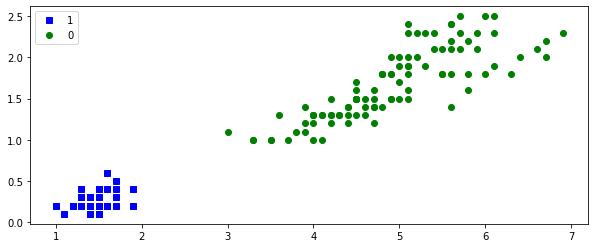

In [26]:
# Quick look at the data
plt.figure(figsize=(10, 4))
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="1")
plt.plot(X[y==0, 0], X[y==0, 1], "go", label="0")
plt.legend()
plt.show()

In [27]:
# Create plotting fxn, This function creates a grid
# to make predictions and then draw a contour. Additionally
# it plots the data on top.
def plot_results(clf, X, y, ax):
    
    # Create grid of predictions
    x0, x1 = np.meshgrid(
            np.linspace(-2, 8, 250).reshape(-1, 1),
            np.linspace(-1, 3.5, 250).reshape(-1, 1),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    
    y_predict = clf.predict(X_new)
        
    # Make into grid
    zz = y_predict.reshape(x0.shape)    

    # Plot
    cf = ax.contourf(x0, x1, zz, cmap='bone')
    N = len(y)
    if N > 200: # If lots of data use transparency 
        ax.plot(X[y==1, 0], X[y==1, 1], 'ow',markeredgecolor=[.5,.5,.5], label="1", alpha=.5)
        ax.plot(X[y==0, 0], X[y==0, 1], 'o',markeredgecolor=[.5,.5,.5],color=[0.25, 0.25, 0.25], label="0", alpha=.5)
    else:
        ax.plot(X[y==1, 0], X[y==1, 1], 'ow',markeredgecolor=[.5,.5,.5], label="1")
        ax.plot(X[y==0, 0], X[y==0, 1], 'o',markeredgecolor=[.5,.5,.5],color=[0.25, 0.25, 0.25], label="0")
            
    ax.legend()

  

### Logistic Regression

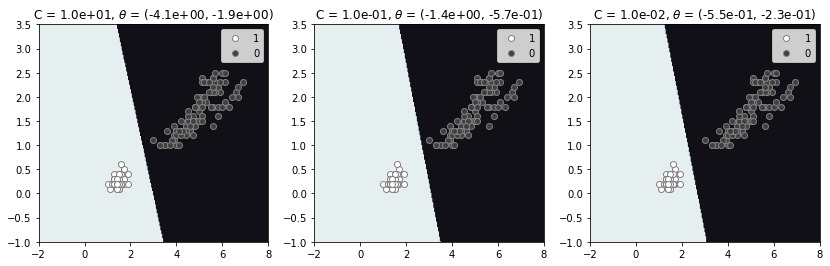

In [28]:
from sklearn.linear_model import LogisticRegression

# Plot model solution and data
fig, axs = plt.subplots(1,3,figsize=(14,4))

vC = [10, 0.1, 0.01]
for i,C in enumerate(vC):
    log_clf = LogisticRegression(C=C)
    log_clf.fit(X,y)
    plot_results(log_clf, X, y,axs[i])
    tstr = r'C = {:2.1e}, $\theta$ = ({:2.1e}, {:2.1e})'.format(C,log_clf.coef_[0][0],log_clf.coef_[0][1])
    axs[i].set_title(tstr)
    


The logistic regression looks as we'd expect, with a linear delineation separating the two classes, minimzing the squared error. Increasing regularization (decreasing C) steepens the curve which seems unintuitive, but we should remember that in creasing regularizatin we are only minimizing the model parameters, which see do get smaller. The classification space, in this case happens to rotate into a steeper looking delineation.

### Linear Support Vector Machine

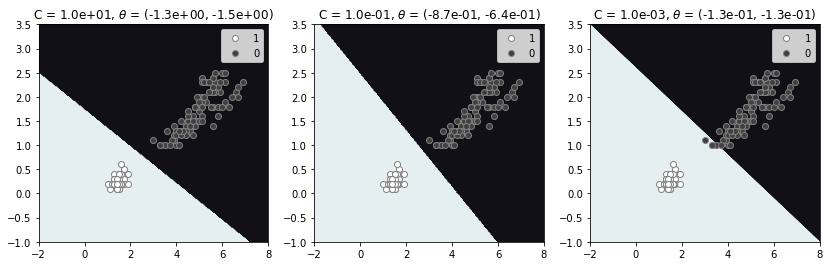

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
scaler = StandardScaler()

# maximum interations, make big, despite scaling sometimes have convergence errors
miter = 50000

# Plot model solution and data
fig, axs = plt.subplots(1,3,figsize=(14,4))

vC = [10, 0.1, 0.001]
for i,C in enumerate(vC):
    # Linear SVM
    svm_clf = LinearSVC(C=C, loss="hinge", max_iter=miter)
    scaled_svm_clf = Pipeline([
        ('scaler', scaler),
        ('linear_scv', svm_clf),
    ])
    scaled_svm_clf.fit(X, y)
    plot_results(scaled_svm_clf, X, y, axs[i])
    tstr = r'C = {:2.1e}, $\theta$ = ({:2.1e}, {:2.1e})'.format(C,svm_clf.coef_[0][0],svm_clf.coef_[0][1])
    axs[i].set_title(tstr)
    
plt.show()

Here, the results look similar to the logistic regression, but regularization does not as strong of an effect graphically.

### Non-linear Support Vector Machine

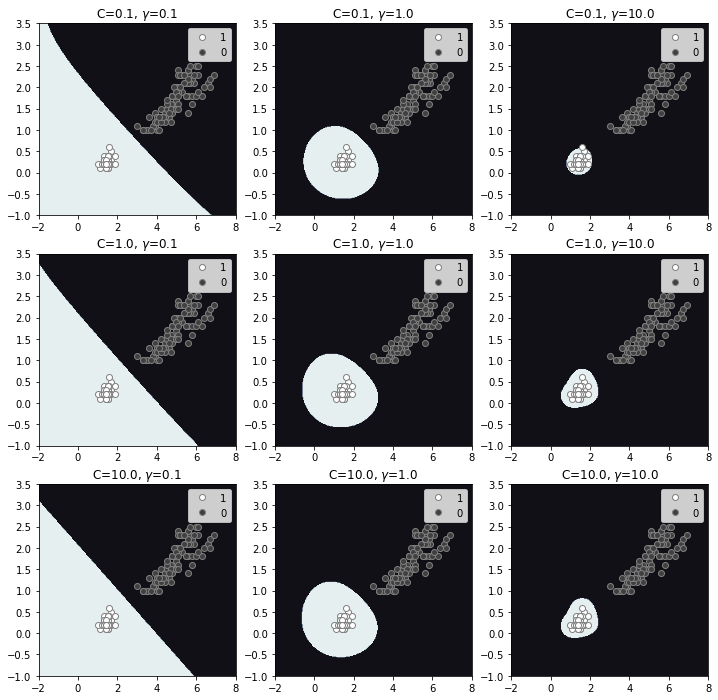

In [30]:
# Note options for kernel, {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
scaler = StandardScaler()

# Plot model solution and data
fig, axs = plt.subplots(3,3,figsize=(12,12))
    
vC = [.1, 1, 10]
vgamma = [0.1, 1, 10]

for i, C in enumerate(vC):
    for j, gamma in enumerate(vgamma):        
        nl_svm_clf = SVC(kernel="rbf", gamma=gamma, C=C)
        scaled_nl_svm_clf = Pipeline([
            ('scaler', scaler),
            ('nonlinear_scv', nl_svm_clf),
        ])        
        scaled_nl_svm_clf.fit(X, y)
        plot_results(scaled_nl_svm_clf, X, y, axs[i,j])
        axs[i,j].set_title(r'C={:.1f}, $\gamma$={:.1f}'.format(C,gamma))

plt.show()

What's really nice about SVMs is that we can relatively easily, and quickly utilize non-linear solutions (through the "kernel trick") and still be guarenteed a convex solution space without local minimums. Here, the inverse of C still controls the regularizatin while an additional parameter $\gamma$, controls the degree of non-linearity. Increasing $\gamma$ allows for more *wiggles* to better fit the data, but this can of course, also lead to overfitting. Here however, a simpler model preferred, and likely adding non-linearity is not warranted.

Note that here we used the radial basis function (rbf), which is just one option for the kernel, and in this case the most reasonable, but it worth exploring the others

### Decision Tree

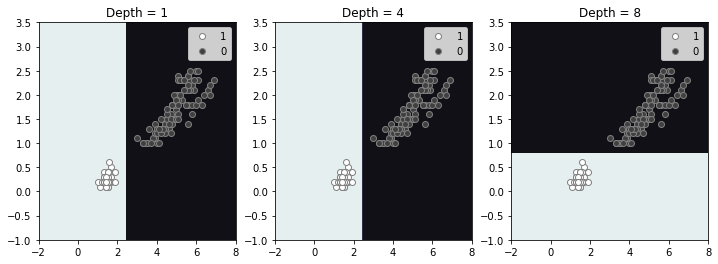

In [31]:
from sklearn.tree import DecisionTreeClassifier

fig, axs = plt.subplots(1,3,figsize=(12,4))

vD = [1, 4, 8]

for i, D in enumerate(vD):
    tree_clf = DecisionTreeClassifier(max_depth=D)
    tree_clf.fit(X,y)
    plot_results(tree_clf, X, y, axs[i])
    axs[i].set_title('Depth = {:d}'.format(D))

plt.show()

Implementing a decision tree here illustrates how with increasing depth we have increasing squared detail. In a way the solution is very linear but in a "boxy" sort of way. This follows from the nature of a decision tree have specific values for a given feature for which a decisions is made

### Random Forrest

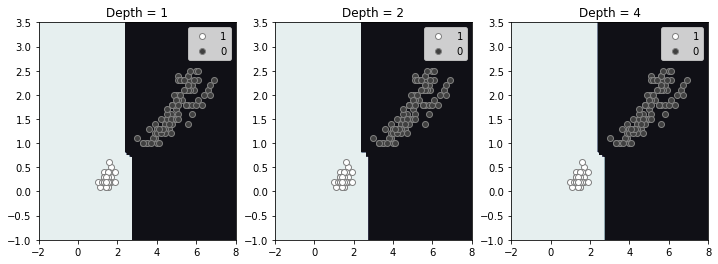

In [32]:
from sklearn.ensemble import RandomForestClassifier

fig, axs = plt.subplots(1,3,figsize=(12,4))

vD = [1, 2, 4]

for i, D in enumerate(vD):
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=D)
    rf_clf.fit(X,y)
    plot_results(rf_clf, X, y, axs[i])
    axs[i].set_title('Depth = {:d}'.format(D))

plt.show()

Results from a random forest, that is, many and in this case 100 different decision trees allow for much more structure in the model space. An upside here is that even with a shallow depth, we can map more complexity. Two downsides that pop out immediately are that (1) the results are random and will vary with iteration, and (2) overfitting appears more likely, for instance some of the fine structure when allowed a depth of 4 appears very unlikely the true model space.

### K-nearest Neighbors

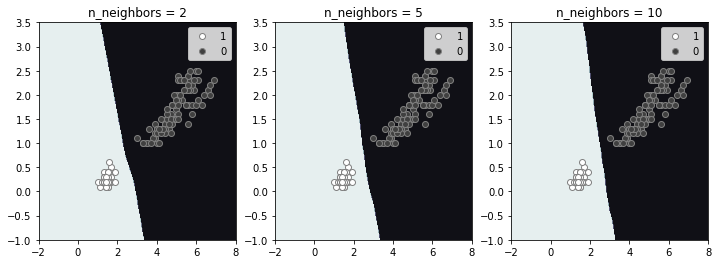

In [33]:
from sklearn.neighbors import KNeighborsClassifier

fig, axs = plt.subplots(1,3,figsize=(12,4))

vD = [2, 5, 10]

for i, D in enumerate(vD):
    knn_clf = KNeighborsClassifier(n_neighbors=D)
    knn_clf.fit(X,y)
    plot_results(knn_clf, X, y, axs[i])
    axs[i].set_title('n_neighbors = {:d}'.format(D))

plt.show()


K-nearest Neighbors makes a plausible decision space with increasing K reducing noise and potential overfitting, but also reducing features that may be desired. 

### Neural Network, MLP Classifier

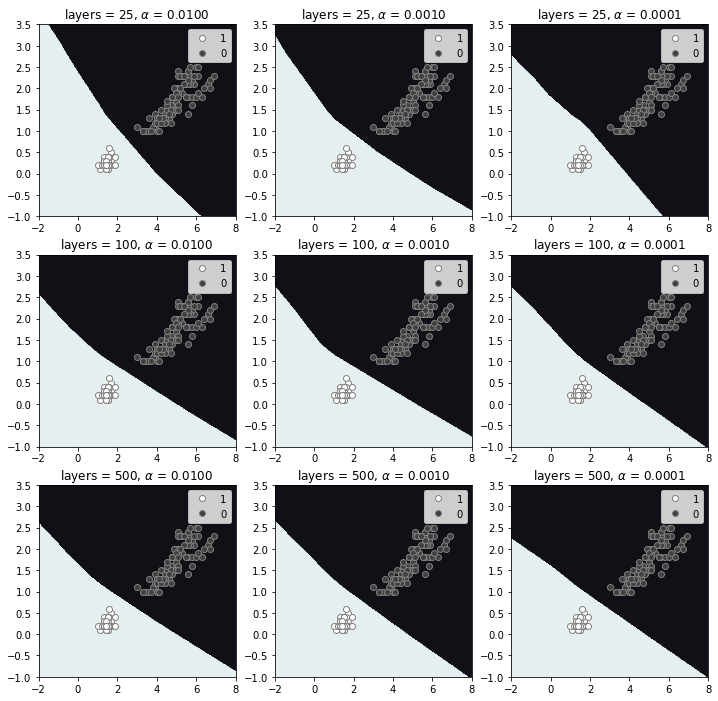

In [34]:
from sklearn.neural_network import MLPClassifier

fig, axs = plt.subplots(3,3,figsize=(12,12))
# axs = axs.ravel() # Make matrix a list

vlayer = [25, 100, 500]
valpha = [0.01, 0.001, 0.0001]

for i, layer in enumerate(vlayer):
    for j, alpha in enumerate(valpha):
        
        mlp_clf = MLPClassifier(max_iter=5000, hidden_layer_sizes=layer, alpha=alpha)
        mlp_clf.fit(X,y)
        plot_results(mlp_clf, X, y, axs[i,j])
        axs[i,j].set_title(r'layers = {:d}, $\alpha$ = {:.4f}'.format(layer,alpha))

plt.show()

Employing a neural network is certainly more computationally costly and leads to possible solutions, here with a bit more curve than the linear models explored previously